# Project-3 : Eyes Classification
Name: Andrea Percy Francis\
Student id: 200555646 

In [1]:
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
from skimage.feature import hog
import numpy as np
from skimage import io, color
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

**Performing EDA & data preprocessing** 

Number of Male Images: 6323
Number of Female Images: 5202


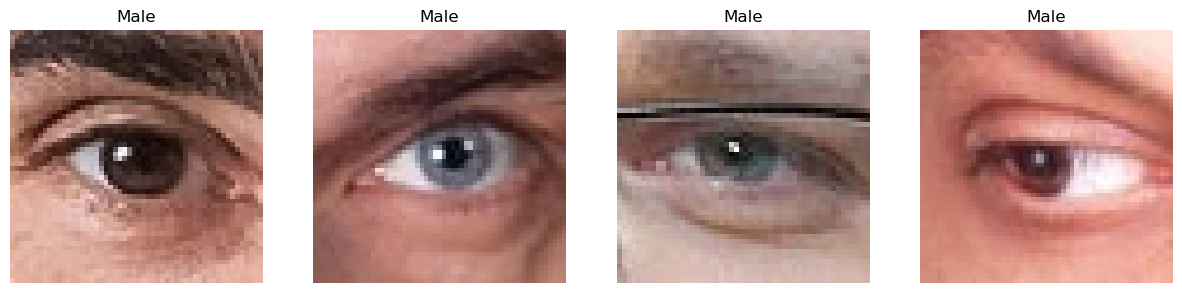

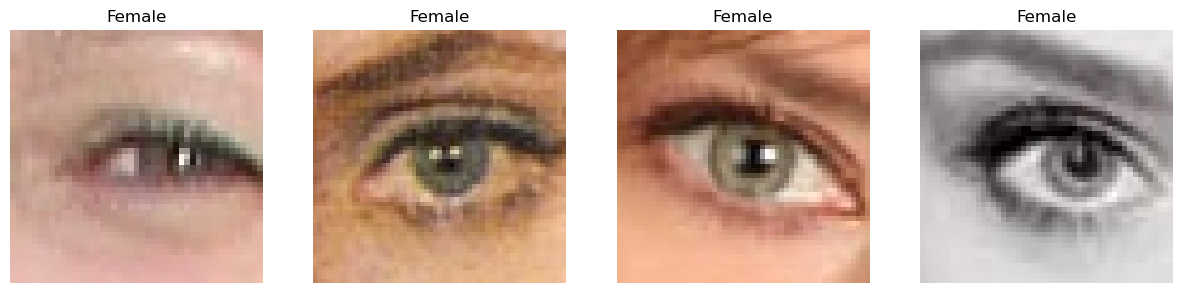

In [2]:
# Defining the paths to the datasets
male_folder = '/Users/andreapercy/Documents/Georgian related/assignments-sem 2/NeuralNtwk-Arch/Assignment 3/maleeyes'
female_folder = '/Users/andreapercy/Documents/Georgian related/assignments-sem 2/NeuralNtwk-Arch/Assignment 3/femaleeyes'


male_images = glob.glob(os.path.join(male_folder, '*.jpg'))
female_images = glob.glob(os.path.join(female_folder, '*.jpg'))

print(f"Number of Male Images: {len(male_images)}")
print(f"Number of Female Images: {len(female_images)}")

# Step 2: Display a few sample images
def plot_sample_images(folder, gender_label, num_samples=4):
    images = glob.glob(os.path.join(folder, '*.jpg'))
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        img_path = images[i]
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(gender_label)
        axes[i].axis('off')

    plt.show()

# Display sample images for male and female
plot_sample_images(male_folder, 'Male')
plot_sample_images(female_folder, 'Female')

# Step 3: Check for image dimensions
def check_image_dimensions(folder):
    image_dimensions = []
    images = glob.glob(os.path.join(folder, '*.jpg'))
    
    for img_path in images:
        img = Image.open(img_path)
        width, height = img.size
        image_dimensions.append((width, height))
    
    return image_dimensions

male_dimensions = check_image_dimensions(male_folder)
female_dimensions = check_image_dimensions(female_folder)




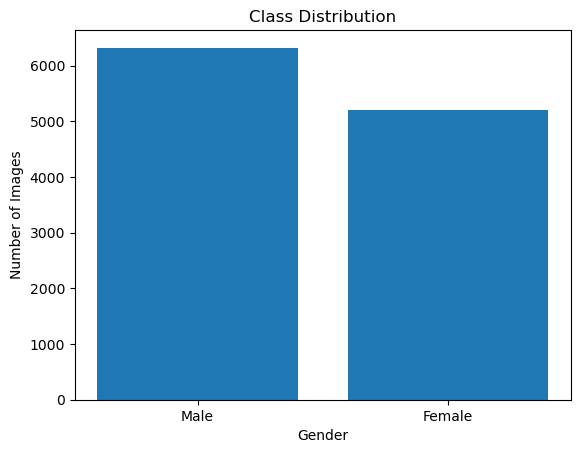

In [3]:
# Checking for class imbalance
class_distribution = {'Male': len(male_images), 'Female': len(female_images)}

# Plot a bar chart for class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title('Class Distribution')
plt.xlabel('Gender')
plt.ylabel('Number of Images')
plt.show()


**Balancing the imbalance in the dataset**

In [4]:
def load_images(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = color.rgb2gray(io.imread(img_path))
            images.append(img)
            labels.append(1 if 'female' in folder else 0)  # Assuming male is the other class
    return images, labels

male_images, male_labels = load_images(male_folder)
female_images, female_labels = load_images(female_folder)

# Combining male and female data
all_images = male_images + female_images
all_labels = male_labels + female_labels
target_dim = 72
# Extracting HOG features
def extract_hog_features(images, target_dim):
    hog_features = []
    for img in images:
        fd, hog_image = hog(
            img.squeeze(),
            orientations=8,
            pixels_per_cell=(16, 16),
            cells_per_block=(1, 1),
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        # Padding the feature vector to match the target dimension
        if len(fd) < target_dim:
            fd = np.pad(fd, (0, target_dim - len(fd)))
        elif len(fd) > target_dim:
            fd = fd[:target_dim]
        hog_features.append(fd)
    return np.vstack(hog_features)

all_hog_features = extract_hog_features(all_images, target_dim)
ros = RandomOverSampler(random_state=42)
all_hog_features_resampled, all_labels_resampled = ros.fit_resample(all_hog_features, all_labels)


**Implementation of the 3 classification models**

In [5]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_hog_features_resampled, all_labels_resampled, test_size=0.2, random_state=42)


**Model 1 - Benchmark model (SVM or KNN Classifier from Sklearn)**

In [6]:
# Creating an SVM model with a pipeline for scaling the data
model_svm = make_pipeline(StandardScaler(), SVC(class_weight='balanced'))

# Training the SVM model
model_svm.fit(X_train, y_train)

# Making predictions on the test set
y_pred_svm = model_svm.predict(X_test)

# Evaluate the SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy_svm}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.7304347826086957
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1300
           1       0.72      0.73      0.72      1230

    accuracy                           0.73      2530
   macro avg       0.73      0.73      0.73      2530
weighted avg       0.73      0.73      0.73      2530



**Model 2 - Multilayer Perceptron Model** 

In [7]:
y_train = np.array(y_train)
y_test = np.array(y_test)
input_shape = (all_hog_features.shape[1],)

# Building the MLP model
mlp_model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the MLP model
mlp_history = mlp_model.fit(
    np.array(X_train),
    y_train,
    epochs=20,
    validation_data=(np.array(X_test), y_test),  # Convert X_test to a NumPy array
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/20
317/317 [==============================] - 1s 1ms/step - loss: 0.6750 - accuracy: 0.5739 - val_loss: 0.6577 - val_accuracy: 0.6091
Epoch 2/20
317/317 [==============================] - 0s 779us/step - loss: 0.6487 - accuracy: 0.6224 - val_loss: 0.6314 - val_accuracy: 0.6577
Epoch 3/20
317/317 [==============================] - 0s 710us/step - loss: 0.6300 - accuracy: 0.6458 - val_loss: 0.6185 - val_accuracy: 0.6696
Epoch 4/20
317/317 [==============================] - 0s 717us/step - loss: 0.6207 - accuracy: 0.6536 - val_loss: 0.6086 - val_accuracy: 0.6684
Epoch 5/20
317/317 [==============================] - 0s 716us/step - loss: 0.6147 - accuracy: 0.6613 - val_loss: 0.6070 - val_accuracy: 0.6719
Epoch 6/20
317/317 [==============================] - 0s 707us/step - loss: 0.6065 - accuracy: 0.6690 - val_loss: 0.6038 - val_accuracy: 0.6692
Epoch 7/20
317/317 [==============================] - 0s 695us/step - loss: 0.6031 - accuracy: 0.6717 - val_loss: 0.5971 - val_accuracy: 0

**Model 3 – CNN model**

In [8]:
input_shape = (72, 1)
X_train_reshaped = X_train.reshape(-1, 72, 1)
X_test_reshaped = X_test.reshape(-1, 72, 1)
# Building the CNN model
cnn_model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=input_shape),
    MaxPooling1D(2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compiling the CNN model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_history = cnn_model.fit(
    X_train_reshaped, y_train,
    epochs=20,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/20
317/317 [==============================] - 1s 3ms/step - loss: 0.6501 - accuracy: 0.6152 - val_loss: 0.6044 - val_accuracy: 0.6656
Epoch 2/20
317/317 [==============================] - 1s 3ms/step - loss: 0.6043 - accuracy: 0.6733 - val_loss: 0.5857 - val_accuracy: 0.6834
Epoch 3/20
317/317 [==============================] - 1s 3ms/step - loss: 0.5913 - accuracy: 0.6877 - val_loss: 0.5763 - val_accuracy: 0.6889
Epoch 4/20
317/317 [==============================] - 1s 3ms/step - loss: 0.5814 - accuracy: 0.6986 - val_loss: 0.5733 - val_accuracy: 0.6984
Epoch 5/20
317/317 [==============================] - 1s 4ms/step - loss: 0.5754 - accuracy: 0.6977 - val_loss: 0.5705 - val_accuracy: 0.6992
Epoch 6/20
317/317 [==============================] - 1s 3ms/step - loss: 0.5725 - accuracy: 0.7084 - val_loss: 0.5639 - val_accuracy: 0.7095
Epoch 7/20
317/317 [==============================] - 1s 3ms/step - loss: 0.5645 - accuracy: 0.7095 - val_loss: 0.5634 - val_accuracy: 0.7091
Epoch 

##### **Model 2: Multilayer Perceptron (MLP)**
**i. Intuition:**
An MLP's architecture is intended to learn complicated patterns in data by directing it via numerous layers of neurons. The network is able to learn hierarchical characteristics because to the hidden layers. The ReLU activation function brings non-linearity into the model, allowing it to learn more effectively from data.\
**ii. Methods Used:** \
Dropout: To prevent overfitting, dropout is used to randomly eliminate a proportion of neurons during training, driving the model to be more resilient.\
Early Stopping: Monitors validation loss and stops training as it begins to increase, reducing overfitting.\
**iii. & iv. Plotting Loss and Accuracy:**


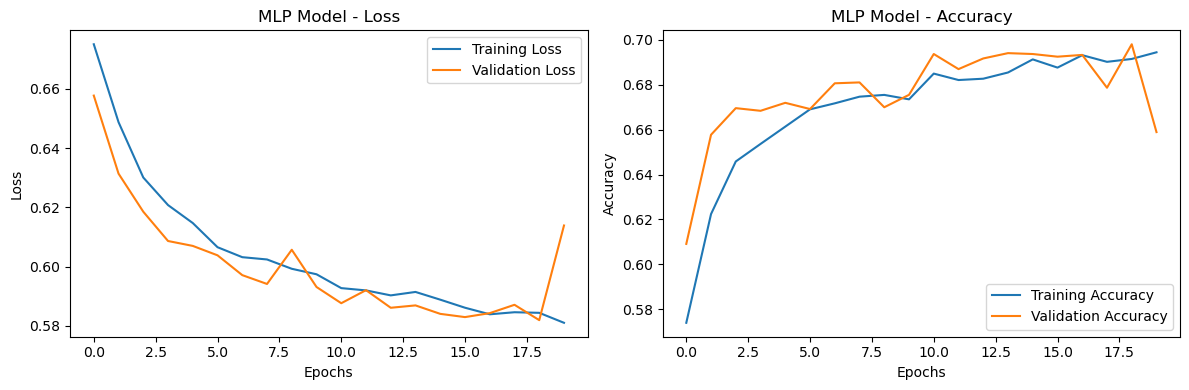

In [9]:
# Plot of training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_history.history['loss'], label='Training Loss')
plt.plot(mlp_history.history['val_loss'], label='Validation Loss')
plt.title('MLP Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot of training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(mlp_history.history['accuracy'], label='Training Accuracy')
plt.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('MLP Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


The training loss is slightly higher than validation in the last epoch.\
The validation accuracy was higher than training accuracy which is good

##### **Model 3: Convolutional Neural Network (CNN)**
**i. Intuition:**
CNN architecture was created to detect spatial hierarchies and patterns in picture data. Convolutional layers with filters detect edges and textures, whereas pooling layers minimise spatial dimensions while retaining key information. In the end, fully linked layers incorporate high-level characteristics for categorization.\
**ii. Techniques Used:** \
Dropout: Used for regularisation on fully linked layers.\
Early Stopping: Monitors validation loss to stop training when overfitting occurs.\
**iii. & iv. Plotting Loss and Accuracy:**


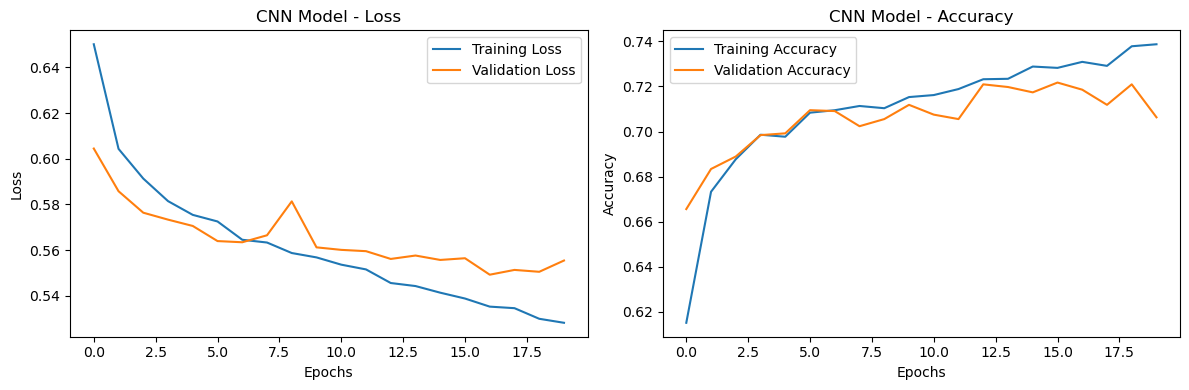

In [10]:
# Plotting of training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting of training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Training loss is lower than validation loss has exponentially decreased over every epoch.\
The training accuracy is higher than validation accuracy

**Performance metrics**

In [11]:
print("Classification Report for SVM Model:")
print(classification_report(y_test, y_pred_svm))

Classification Report for SVM Model:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1300
           1       0.72      0.73      0.72      1230

    accuracy                           0.73      2530
   macro avg       0.73      0.73      0.73      2530
weighted avg       0.73      0.73      0.73      2530



In [12]:
y_pred_mlp_probs = mlp_model.predict(X_test)
y_pred_mlp = (y_pred_mlp_probs > 0.5).astype(int)  # binary classification
print("Classification Report for MLP Model:")
print(classification_report(y_test, y_pred_mlp))

80/80 [==============================] - 0s 490us/step
Classification Report for MLP Model:
              precision    recall  f1-score   support

           0       0.76      0.49      0.60      1300
           1       0.61      0.84      0.70      1230

    accuracy                           0.66      2530
   macro avg       0.68      0.66      0.65      2530
weighted avg       0.69      0.66      0.65      2530



In [13]:
y_pred_cnn_probs = cnn_model.predict(X_test_reshaped)
y_pred_cnn = (y_pred_cnn_probs > 0.5).astype(int)  #  binary classification
print("Classification Report for CNN Model:")
print(classification_report(y_test, y_pred_cnn))

80/80 [==============================] - 0s 872us/step
Classification Report for CNN Model:
              precision    recall  f1-score   support

           0       0.70      0.80      0.74      1300
           1       0.75      0.63      0.69      1230

    accuracy                           0.72      2530
   macro avg       0.72      0.72      0.72      2530
weighted avg       0.72      0.72      0.72      2530



**Comparision** \
Accuracy: SVM and CNN models have similar and greater accuracy (0.73) than MLP (0.70).\
Precision (Class 0):
SVM and CNN models have the same accuracy for class 0 (0.74), which is somewhat higher than MLP (0.70).\
Recall (Class 0):
SVM, MLP, and CNN models all show comparable recall for class 0, ranging from 0.73 to 0.74.\
F1-score (Class 0):
SVM, MLP, and CNN models all have similar F1-scores for class 0, ranging from 0.71 to 0.74.\
Precision (Class 1):
SVM has a little greater accuracy for class 1 (0.72) than MLP (0.70) and CNN (0.72).\
Recall (Class 1):

**Conclusion:**

SVM and CNN models perform comparable with an accuracy of 0.73, surpassing MLP with 0.70.\
Class 0 Metrics (Male Prediction):
When predicting males, SVM and CNN models consistently and marginally outperform MLP in terms of accuracy, recall, and F1-score.\
Class 1 Metrics (Female Prediction):
When predicting females, SVM outperforms MLP (precision: 0.70, recall: 0.66). CNN operates similarly to SVM.\
Overall Robustness:
SVM and CNN models outperform in both groups, whereas MLP has a worse recall for predicting females.\
Model Complexity:
MLP and CNN are complicated neural network models, while SVM is a simpler linear model. Despite its simplicity, SVM outperforms other algorithms



